# EDA

In [48]:
import pandas as pd
import geopandas
import geoplot
from shapely.geometry import Polygon, Point
import geoplot.crs as gcrs
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"   
mpl.rcParams['font.size'] = 13
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5

In [2]:
path = 'C:/Users/Zaca/Documents/Datasets/nyc/'

In [3]:
# open data
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)
# transform to datetime
crime['date'] = pd.to_datetime(crime['date'])

C:\Users\Zaca\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
crime.description.value_counts()[:20]

PETIT LARCENY                     984505
HARRASSMENT 2                     733522
ASSAULT 3 & RELATED OFFENSES      623550
CRIMINAL MISCHIEF & RELATED OF    594719
GRAND LARCENY                     505759
DANGEROUS DRUGS                   369783
OFF. AGNST PUB ORD SENSBLTY &     310818
FELONY ASSAULT                    227046
ROBBERY                           216401
BURGLARY                          203927
MISCELLANEOUS PENAL LAW           148146
DANGEROUS WEAPONS                 138989
OFFENSES AGAINST PUBLIC ADMINI    118389
GRAND LARCENY OF MOTOR VEHICLE    103253
INTOXICATED & IMPAIRED DRIVING     82341
VEHICLE AND TRAFFIC LAWS           72680
CRIMINAL TRESPASS                  69732
SEX CRIMES                         66807
THEFT-FRAUD                        61160
FORGERY                            58875
Name: description, dtype: int64

In [5]:
crime.premises.value_counts()[:20]

STREET                          1913118
RESIDENCE - APT. HOUSE          1250281
RESIDENCE-HOUSE                  566636
RESIDENCE - PUBLIC HOUSING       452722
OTHER                            160590
COMMERCIAL BUILDING              152028
TRANSIT - NYC SUBWAY             129121
CHAIN STORE                      127502
DEPARTMENT STORE                 120639
GROCERY/BODEGA                    74802
PUBLIC SCHOOL                     71084
PARK/PLAYGROUND                   71021
RESTAURANT/DINER                  69162
BAR/NIGHT CLUB                    66898
DRUG STORE                        51226
CLOTHING/BOUTIQUE                 50823
PUBLIC BUILDING                   36596
PARKING LOT/GARAGE (PUBLIC)       33483
FOOD SUPERMARKET                  32952
PARKING LOT/GARAGE (PRIVATE)      30842
Name: premises, dtype: int64

In [22]:
violent = ['FELONY ASSAULT', 'ROBBERY', 'RAPE']
propert = ['BURGLARY', 'ARSON', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE']

crime_filter = ['BURGLARY', 'ROBBERY']
crime_subset = crime[crime.description.isin(crime_filter)]

In [23]:
# open shapefile
pcints = geopandas.read_file(path + 'nypd_precincts.shp').to_crs(epsg=4326)

# clean a variable dtypes
pcints['pct'] = pcints['pct'].astype('int32')

# create a new, clean GeoDataFrame
clean_map = geopandas.GeoDataFrame()
clean_map['precinct'] = pcints['pct'].unique()
clean_map['geometry'] = [Polygon(max(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union, key=lambda a: a.area).exterior) if pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.geom_type == 'MultiPolygon' else Polygon(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.exterior) for pct in clean_map.precinct]

In [24]:
def choropleth_text(basemap):
    
    basemap['coords'] = basemap['geometry'].apply(lambda x: x.representative_point().coords[:])
    basemap['coords'] = [coords[0] for coords in basemap['coords']]
    bbox_props = dict(boxstyle='round,pad=0.25', fc='white', ec='black')
    
    #base = basemap.plot(figsize=(12, 12), color='white', edgecolor='black', lw= 1, alpha=0.5)
    ax = geoplot.choropleth(basemap, hue='count', figsize=(12, 12), lw= 1, edgecolor='k', alpha=1, cmap='plasma', projection=gcrs.AlbersEqualArea())
    
    #for idx, row in basemap.iterrows():
        #base.text(s=str(row['precinct']), x=row['coords'][0], y=row['coords'][1], bbox = bbox_props, fontsize=10)

In [25]:
#clean_map = clean_map.merge(crime.groupby(by='precinct').agg(count=('time', 'count')).reset_index(), on='precinct')
#clean_map.sort_values(by='count', ascending=False, inplace=True)
#clean_map

,precinct,geometry,count
67,75,"POLYGON ((-73.86034 40.65496, -73.86030 40.654...",193541
56,43,"POLYGON ((-73.85515 40.81437, -73.85532 40.814...",154912
57,44,"POLYGON ((-73.92455 40.81871, -73.92518 40.818...",148552
52,40,"POLYGON ((-73.90229 40.80456, -73.90245 40.804...",140763
9,14,"POLYGON ((-73.97948 40.75540, -73.97787 40.754...",135083
...,...,...,...
6,111,"POLYGON ((-73.75652 40.72628, -73.75670 40.726...",36393
12,121,"POLYGON ((-74.15253 40.58062, -74.15253 40.580...",35896
68,76,"POLYGON ((-73.99877 40.67160, -73.99877 40.671...",33146
76,100,"POLYGON ((-73.82836 40.57914, -73.82838 40.579...",31099


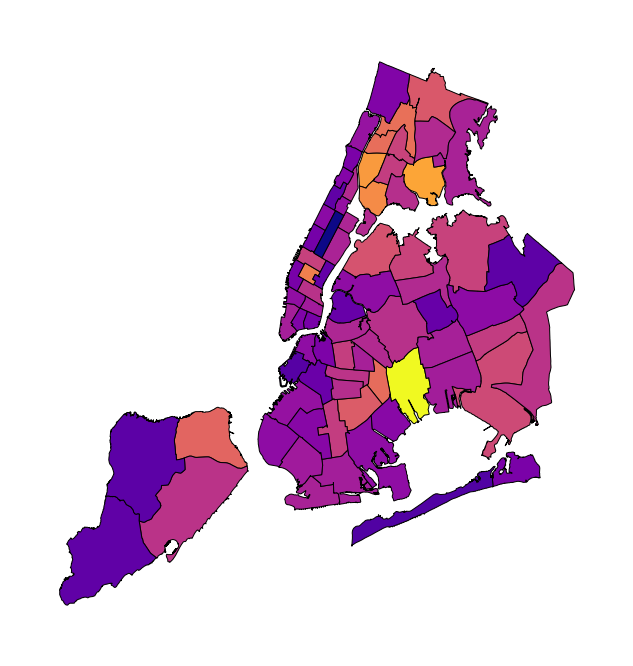

In [33]:
choropleth_text(clean_map)

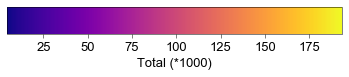

In [49]:
def make_colorbar(data, units, cmap, filename):
    
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    
    norm = mpl.colors.Normalize(vmin=min(data), vmax=max(data))

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
    cb1.set_ticks([25000, 50000, 75000, 100000, 125000, 150000, 175000])
    cb1.set_ticklabels(['25', '50', '75', '100', '125', '150', '175'])
    cb1.set_label(units)
    plt.savefig(filename)
    
make_colorbar(clean_map['count'], 'Total (*1000)', mpl.cm.get_cmap('plasma'), 'figures/precinct_heatmap_colorbar.png')

In [ ]:
historical = [184652, 162908, 154809, 147069, 142093, 135475, 128682, 121009, 117956, 106730, 105115, 106669, 111147, 111,335 106,722 105,453 101,716 96,658 95,883 95606